In [2]:
 %load_ext autoreload

In [28]:
%autoreload 2

In [29]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import urllib
from bs4 import BeautifulSoup
import requests
from astropy.io import fits
from astropy.table import Table
import glob
import scipy.integrate
import scipy.stats
import scipy.interpolate
import scipy.optimize
import scipy.signal
import scipy.ndimage
import scipy.spatial
from ProfileClass import PulsarProfile
# import ProfileClass

# Auxilary functions

In [32]:
def is_float(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

# ATNF Database

In [33]:
lines = []
with open('psrcat.db') as f:
    lines = f.readlines()
dict_list = []
tmp_dict = {}
for line in lines:
    if len(line,) == 0:
        print("ERROR: Zero length line")
        break
    if line[0] == '@':
        dict_list.append(tmp_dict)
        tmp_dict = {}
    else:
        splitted_line = line.split()
        if(is_float(splitted_line[1])):
            tmp_dict[splitted_line[0]] = float(splitted_line[1])
        else:
            tmp_dict[splitted_line[0]] = splitted_line[1]
data = pd.DataFrame(dict_list)
data.loc[data['F0'].notna(), 'P0'] = 1 / data['F0']
data.loc[data['P0'].notna(), 'F0'] = 1 / data['P0']
data.loc[data['F0'].notna() & data['F1'].notna(), 'P1'] = -data['F1'] / data['F0']**2 
data.loc[data['P0'].notna() & data['P1'].notna(), 'F1'] = -data['P1'] / data['P0']**2

data['B12'] = (data['P0'] * data['P1'] * 1e15)**0.5
data['AGE'] = data['P0'] / data['P1'] / 2
data['Q'] = data['P0']**(5/7) / (data['P1']*1e15)**(2/7)
data['L1400'] = data['S1400'] * data['DIST_DM']**2
data['L'] = 7.4e27 * data['L1400']
data['Edot'] = 3.95 * 1e31 * (data['P1'] / 1e-15)/ data['P0']**3
data['Eff'] = data['L'] / data['Edot']
data = data.set_index('PSRJ')

# Pulsars mean profiles database (.fits)

# FAST profiles

In [34]:
# ----downloading-----
# url = 'http://zmtt.bao.ac.cn/psr-fast/'
# reqs = requests.get(url)
# soup = BeautifulSoup(reqs.text, 'html.parser')
 
# urls = []
# for link in soup.find_all('a'):
#     link_string = link.get('href')
#     if link_string.split('/')[0] == 'whx23dat':
#         print(link_string.split('/')[1])
#         urllib.request.urlretrieve(url+link_string, 'FAST_profiles/' + link_string.split('/')[1])

In [35]:
FASTfiles = glob.glob('FAST_Profiles/*')
FASTnames = []
for file in FASTfiles:
    name = file.split('/')[1]
    name = name.split('I')[0]
    name = name.replace('p', '+')
    name = name.replace('m', '-')
    FASTnames.append(name)
FASTProfiles = pd.DataFrame({'PSRJ': FASTnames, 'FASTfile_name': FASTfiles})
FASTProfiles = FASTProfiles.set_index('PSRJ')
FASTTable = pd.read_csv('KAT?.csv')
FASTTable.set_index('PSRJ', inplace=True)
FASTTable = FASTTable[~FASTTable.index.duplicated(keep='first')]
print(FASTTable)
FASTTable.rename(columns={'W10': 'W10_custom'}, inplace=True) #do not exist in Table!!!
FASTTable.rename(columns={'Mode': 'Mode_FAST'}, inplace=True)
FASTProfiles = FASTProfiles.merge(FASTTable, how='left', left_index=True, right_index=True)
data = data.merge(FASTProfiles, how='left', left_index=True, right_index=True)

            Mode
PSRJ            
J0011+08      Od
J0848+16     Od?
J1312+1810A   Od
J1538+2345    Od
J1641+3627A   Od
...          ...
J2129+1210A    ?
J2129+4119     ?
J2138+4911     ?
J2208+4056    Os
J2340+08       ?

[198 rows x 1 columns]


## MeerKAT profiles

In [36]:
MeerKATfiles = glob.glob('MeerKAT_Profiles/ar_files/*')
MeerKATnames = []
for file in MeerKATfiles:
    MeerKATnames.append(file.split('/')[2].split('_')[0])
MeerKATProfiles = pd.DataFrame({'PSRJ': MeerKATnames, 'MeerKATfile_name': MeerKATfiles})
MeerKATTable = pd.read_csv('MeerKat.csv')
MeerKATTable.set_index('PSRJ', inplace=True)
MeerKATTable.rename(columns={'W10': 'W10_custom'}, inplace=True)
MeerKATTable.rename(columns={'Mode': 'Mode_MeerKAT'}, inplace=True)

MeerKATProfiles = MeerKATProfiles.set_index('PSRJ')
MeerKATProfiles = MeerKATProfiles.merge(MeerKATTable, how='left', left_index=True, right_index=True)
data = data.merge(MeerKATProfiles, how='left', left_index=True, right_index=True)

In [37]:
MeerKATProfiles.loc['J0514-4407']

MeerKATfile_name    MeerKAT_Profiles/ar_files/J0514-4407_2020-02-2...
Mode_MeerKAT                                                      NaN
W10_custom                                                        NaN
Name: J0514-4407, dtype: object

## EPN profiles

In [38]:
EPN_PSR_folders = glob.glob('EPN_ALL/fits/**/*')

In [39]:
EPNnames = []
for folder in EPN_PSR_folders:
    name = folder.split('/')[-1]
    if name[0] == 'B':
        name = data.index[data['PSRB'] == name][0]
    EPNnames.append(name)

# EPN_Profiles = pd.DataFrame({'PSRJ': EPNnames, 'EPNfolder': EPN_PSR_folders})
# EPN_Profiles = EPN_Profiles.set_index('PSRJ')

In [40]:
EPN_Profiles_dict = dict.fromkeys(EPNnames, [])
for i in range(len(EPN_PSR_folders)):
    folder = EPN_PSR_folders[i]
    files = glob.glob(folder+'/*')
    EPN_Profiles_dict[EPNnames[i]] = EPN_Profiles_dict[EPNnames[i]] + files #!!! do not use += 

# Useful subsets

## Fast and MeerKAT subsets

In [20]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()

## FAST orthogonal subset

In [ ]:
orthogonal_PSRs_FAST = []
for psr in FASTnames:
    profile = ProfileClass.PulsarProfile(FASTProfiles.loc[psr]['FASTfile_name'], 'FAST')
    if profile.profile_type == 'orthogonal':
        # plt.plot(np.linspace(0, 1, pulsar_data[0].shape[0]), pulsar_data[0])
        orthogonal_PSRs_FAST.append(psr)
orthogonalFASTs = data[data.index.isin(orthogonal_PSRs_FAST)].copy()
print(np.sort(np.array(orthogonal_PSRs_FAST)))


['J0337+1715' 'J0653+4706' 'J0827+53' 'J1628+4406' 'J1630+3734'
 'J1842+0358' 'J1849+0409' 'J1851+0118' 'J1851+0418' 'J1852+0056g'
 'J1853+1303' 'J1855+0700' 'J1857+0943' 'J1909+0749' 'J1913+0832'
 'J1913+1050' 'J1918+1541' 'J1921+0137' 'J1926+0737' 'J1934+2352'
 'J1935+2025' 'J1939+2134' 'J1959+2048' 'J2004+3429' 'J2023+5037'
 'J2032+4127' 'J2047+5029' 'J2053+4650' 'J2208+4056']


## MeerKAT orthogonal subset

In [ ]:
orthogonal_PSRs_MeerKAT = []
for psr in MeerKATnames:
    if not psr in data.index:
        continue
    profile = PulsarProfile(MeerKATProfiles.loc[psr]['MeerKATfile_name'], 'MeerKAT')
    if profile.profile_type == 'orthogonal':
        # plt.plot(np.linspace(0, 1, pulsar_data[0].shape[0]), pulsar_data[0])
        orthogonal_PSRs_MeerKAT.append(psr)
orthogonalMeerKATs = data[data.index.isin(orthogonal_PSRs_MeerKAT)].copy()
print(np.sort(np.array(orthogonal_PSRs_FAST)))


['J0337+1715' 'J0653+4706' 'J0827+53' 'J1628+4406' 'J1630+3734'
 'J1842+0358' 'J1849+0409' 'J1851+0118' 'J1851+0418' 'J1852+0056g'
 'J1853+1303' 'J1855+0700' 'J1857+0943' 'J1909+0749' 'J1913+0832'
 'J1913+1050' 'J1918+1541' 'J1921+0137' 'J1926+0737' 'J1934+2352'
 'J1935+2025' 'J1939+2134' 'J1959+2048' 'J2004+3429' 'J2023+5037'
 'J2032+4127' 'J2047+5029' 'J2053+4650' 'J2208+4056']


## Fast and MeerKAT manual mode subsets

In [7]:
MeerKATXs = MeerKATsubset[(MeerKATsubset['Mode_MeerKAT'] == 'Xd') | (MeerKATsubset['Mode_MeerKAT'] == 'Xs')]
MeerKATOs = MeerKATsubset[(MeerKATsubset['Mode_MeerKAT'] == 'Od') | (MeerKATsubset['Mode_MeerKAT'] == 'Os')]
FASTXs = FASTsubset[(FASTsubset['Mode_FAST'] == 'Xd') | (FASTsubset['Mode_FAST'] == 'Xs')]
FASTOs = FASTsubset[(FASTsubset['Mode_FAST'] == 'Od') | (FASTsubset['Mode_FAST'] == 'Os')]

NameError: name 'MeerKATsubset' is not defined

# Profiles processing

# Space for working

In [21]:
peaks = np.array([382, 427])
dists = scipy.spatial.distance.cdist(peaks.reshape((-1, 1)), peak.reshape((-1, 1)), lambda u, v: min((u-v)%N, (v-u)%N))
maxdist = np.max(dists)
print(maxdist)
print(0.9*256)
print(find_profile_type(read_profile_data(FASTProfiles.loc['J1743-0339']['FASTfile_name'], 'FAST')[0]))

NameError: name 'peak' is not defined

## Width statistics: FAST

In [143]:
XW50 = []
OW50 = []
XW10 = []
OW10 = []

for psr in FASTnames:
    pulsar_profile = PulsarProfile(FASTProfiles.loc[psr]['FASTfile_name'], 'FAST')
    if not (pulsar_profile.find_profile_type() == 'single' or pulsar_profile.find_profile_type() == 'double'):
        continue
    if psr in data.index:
        if data.loc[psr]['P0'] < 0.03:
            continue
        # if (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xs') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xd'):
        #     XW50.append(data.loc[psr]['W50'] * data.loc[psr]['P0']**0.5)
        #     if not pd.isna(data.loc[psr]['W10']) and data.loc[psr]['W10'] < 45:
        #         XW10.append(data.loc[psr]['W10'] * data.loc[psr]['P0']**0.5)
        # elif (FASTProfiles.loc[psr]['Mode_FAST'] == 'Os') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Od'):
        #     OW50.append(data.loc[psr]['W50'] * data.loc[psr]['P0']**0.5)
        #     if not pd.isna(data.loc[psr]['W10']) and data.loc[psr]['W10'] < 45:
        #         OW10.append(data.loc[psr]['W10'] * data.loc[psr]['P0']**0.5)
        mode = pulsar_profile.get_mode()
        if mode != '?':
            print(psr, mode, FASTProfiles.loc[psr]['Mode_FAST'])
        if mode == 'X':
            if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
                XW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
            if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
                XW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        elif mode == 'O':
            if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
                OW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
            if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
                OW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        
            

J1903+0135 X nan
J1844+00 X Xd?
J1842+0257 O Os?
J0613+3731 X ?
J0006+1834 X Xd
J1914+1122 O Od
J1411+2551 X nan
J1809+17 X Xs
J1937+1505 X nan
J1838+1523 O nan
J1913+1011 O OX?
J1904+1011 O Od?
J1854+0319 O Od
J2022+5154 X Xs
J1912+1036 X Хs
J1901+0124 X Xs
J1843-0211 O Od
J1823-0154 O ?
J1832+27 O Od
J1938+0650 X Xs
J1931+1439 O Od
J1905+0616 X Xs
J1913+0904 X Xd
J1918+1444 X Xs
J0358+5413 X Xd?
J1919+1745 X Od?
J1932+2220 X Xs
J1946+1805 O Od
J1912+2104 O nan
J1902+0723 O Od
J1910+0728 X Xd
J2113+4644 X OXO?
J1922+1733 X Xd
J1913+3732 X Xd
J1838-01 X nan
J1900+0227 X Xs
J2004+2653 O nan
J1854+0306 O Xs
J1852-0024g X nan
J1830-0052 O nan
J0335+4555 X nan
J1921+1948 X nan
J1907+1149 X nan
J1821+0155 O nan
J2122+2426 X Xs
J1904+0738 X nan
J2243+1518 O nan
J1800+5034 X nan
J1857+0212 O nan
J1842+0638 O nan
J1911+1301 O nan
J1919+0134 O nan
J0543+2329 X Xs
J1952+3252 O Od
J1926+1648 X Xs
J1901+0234 O Os
J1937+2544 X Od?
J2005+3552 X Xs
J1838+0044g O Od?
J1933+1304 X Od
J1312+1810A O Od
J

In [144]:
print(np.median(XW50))
print(np.median(OW50))

5.458395740290108
6.7736633889609426


KstestResult(statistic=0.25223214285714285, pvalue=0.0365013010825992, statistic_location=12.416535409880415, statistic_sign=1)


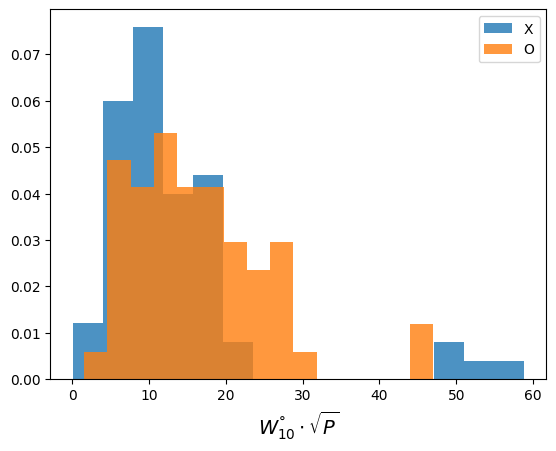

In [146]:
plt.hist(XW10, bins=15, density=True, cumulative=False, alpha=0.8, label='X')
plt.hist(OW10, bins=15, density=True, cumulative=False, alpha=0.8, label='O')
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
plt.legend()
print(scipy.stats.kstest(XW10, OW10))
# plt.show()
# plt.savefig('FAST_density.png', dpi=400, bbox_inches='tight')

## Width statisticks MeerKAT

In [154]:
XW50 = []
OW50 = []
XW10 = []
OW10 = []

for psr in MeerKATnames:
    pulsar_profile = PulsarProfile(MeerKATProfiles.loc[psr]['MeerKATfile_name'], 'MeerKAT')
    if not (pulsar_profile.find_profile_type() == 'single' or pulsar_profile.find_profile_type() == 'double'):
        continue
    if psr in data.index:
        if data.loc[psr]['P0'] < 0.03:
            continue
        # if (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xs') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Xd'):
        #     XW50.append(data.loc[psr]['W50'] * data.loc[psr]['P0']**0.5)
        #     if not pd.isna(data.loc[psr]['W10']) and data.loc[psr]['W10'] < 45:
        #         XW10.append(data.loc[psr]['W10'] * data.loc[psr]['P0']**0.5)
        # elif (FASTProfiles.loc[psr]['Mode_FAST'] == 'Os') or (FASTProfiles.loc[psr]['Mode_FAST'] == 'Od'):
        #     OW50.append(data.loc[psr]['W50'] * data.loc[psr]['P0']**0.5)
        #     if not pd.isna(data.loc[psr]['W10']) and data.loc[psr]['W10'] < 45:
        #         OW10.append(data.loc[psr]['W10'] * data.loc[psr]['P0']**0.5)
        mode = pulsar_profile.get_mode()
        if mode != '?':
            print(psr, mode, MeerKATProfiles.loc[psr]['Mode_MeerKAT'])
        if mode == 'X':
            if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
                XW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
            if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
                XW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
        elif mode == 'O':
            if pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5 < 60:
                OW50.append(pulsar_profile.get_Wa(50) * data.loc[psr]['P0']**0.5)
            if pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5 < 60:
                OW10.append(pulsar_profile.get_Wa(10) * data.loc[psr]['P0']**0.5)
            

J0536-7543 X Xd
J1844-0538 X Xs
J1038-5831 O Od?
J1645-0317 O nan
J0614+2229 X Xs
J1945-0040 O Od
J1709-4429 O Os
J1932-3655 O Xs?
J1259-6741 O Od
J1602-5100 X OXO
J1900-0933 X Od?
J0646+0905 X Xs
J1757-1500 X Xd
J1929+2121 O Os
J2038-3816 O Os
J1456-6843 X nan
J1312-5402 O Os
J1350-5115 O Os
J1845-1114 X Xs
J0633-2015 X Xd
J1222-5738 X Xs
J1751-4657 O Od
J1049-5833 O Os
J1946+1805 O Os
J1759-3107 O Od?
J1524-5706 X Xs
J1543+0929 X nan
J0459-0210 O Xs
J1741-0840 O Od
J1904+1011 O Od?
J0304+1932 O Od
J1830-1059 X Xs
J1231-4609 X Xd
J1842-0359 X Xd?
J0907-5157 X Od
J1851+1259 X Xs
J0835-4510 X Xs
J1727-2739 O Od
J1056-6258 X Xs
J2155-3118 O Os
J2346-0609 O Od
J1020-5921 X Xs?


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:290: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


J1919+1745 X Xd
J1731-4744 O Od
J1932+2220 X Xs
J1850+1335 X Xs
J1932+1059 X Xs
J1914+1122 O Od
J1622-4332 O Od
J1328-4357 X Xs
J0809-4753 X nan
J1403-7646 O Od
J1420-5416 X Xs
J1740-3015 X Xs
J1319-6105 X Xs
J0659+1414 X Xs
J1917+1353 X Xs
J0543+2329 X Xs
J0820-1350 O Od
J1308-5844 X Xs?
J1210-6550 O Os?


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/interpolate/_fitpack_py.py:290: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


J1651-5222 X Xd
J1902+0615 X Xs
J0944-1354 X Xs
J0729-1836 O Od
J1701-3130 O Od?
J1327-6222 O Os
J1926+1648 X Xs
J1119-7936 O Od
J0630-2834 X Xs
J1918+1444 X Xs
J1313+0931 X nan
J0952-3839 O Os?
J0904-4246 O Xd?
J0953+0755 X Xs
J1703-1846 O Os
J1136+1551 O Od
J0855-3331 X nan
J1320-5359 X Xs
J1949-2524 O Os
J2043+2740 X Os
J1709-1640 O Xs?
J1507-4352 X Xs
J0108-1431 X Xs
J1922+1733 X Xd
J1253-5820 X Xs
J1535-4114 X Xd
J1123-6102 X Xs
J1743-3150 O Os
J1844+1454 X Od?
J1534-4428 O Od?
J1938+0650 X Xs
J1105-6107 X Xd
J0945-4833 X Xs
J1232-4742 O Od?
J0627+0649 X nan
J0909-7212 O Od
J1855+0307 X Xs
J1041-1942 O Od?
J1818-1607 O Os
J1912+2104 O Od
J1141-6545 X Xs
J1720-0212 X Xs
J1638-3815 O Od
J1512-5431 O Od
J1901-0906 O OX(O)
J1555-2341 X Xs
J1835-1106 X Xs
J1104-6103 X Xs
J1941-2602 X Xd
J1224-6407 X (O)X(O)?
J1430-6623 O (O)X(O)?
J0902-6325 X nan
J1921+1419 X Os
J0034-0721 O nan
J1123-4844 O Od
J1915+0738 O Os
J1359-6038 X Xs
J1919+0134 O Od
J1847-0438 X Xs
J1903+0135 X Xs
J1605-5257 O

KstestResult(statistic=0.32048517520215636, pvalue=0.0029436808128642054, statistic_location=9.182704935318455, statistic_sign=1)


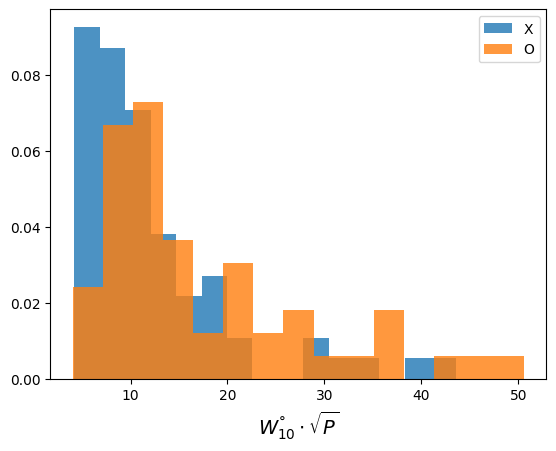

In [156]:
plt.hist(XW10, bins=15, density=True, cumulative=False, alpha=0.8, label='X')
plt.hist(OW10, bins=15, density=True, cumulative=False, alpha=0.8, label='O')
plt.xlabel(r'$W_{10}^\degree \cdot \sqrt{P}$', fontsize=14)
plt.legend()
print(scipy.stats.kstest(XW10, OW10))
# plt.savefig('MeerKAT_density.png', dpi=400, bbox_inches='tight')

/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0.86523438]
24.01171875
X
0.83984375 0.90625


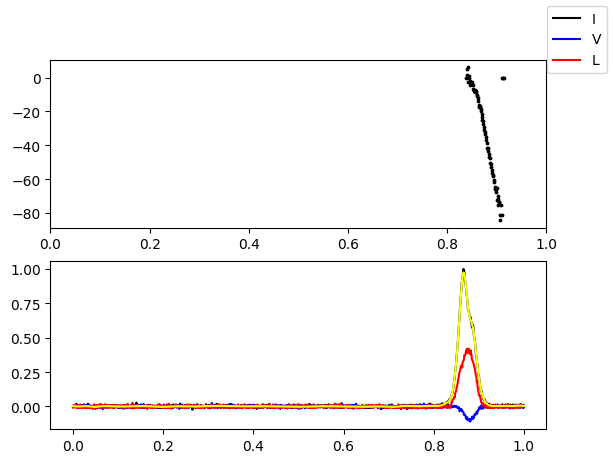

In [142]:
profile = PulsarProfile(data.loc['J1921+1419']['FASTfile_name'], 'FAST')
profile.plot_profile(plot_fit=True)
print(profile.find_peaks()/profile.Ncounts)
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)


/Users/arseniy/Documents/Science/Physics/RadioPulsars/PulsarDataBase/ProfileClass.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[0.23632812 0.24902344]
13.88671875
X
0.23046875 0.2685546875


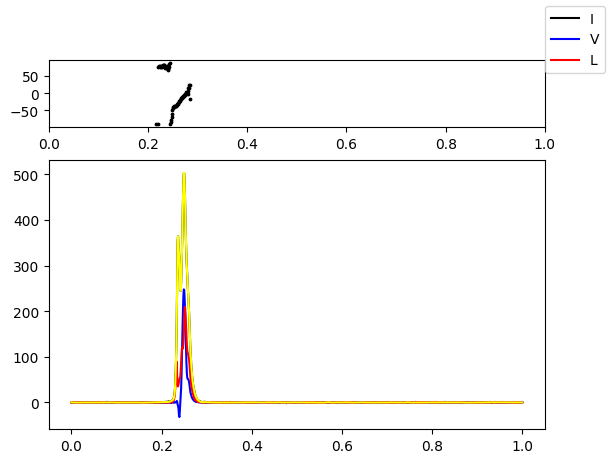

In [159]:
profile = PulsarProfile(data.loc['J1224-6407']['MeerKATfile_name'], 'MeerKAT')
profile.plot_profile(plot_fit=True)
print(profile.find_peaks()/profile.Ncounts)
print(profile.get_Wa(10))
print(profile.get_mode())
print(profile.get_level_bounds(10)[0]/profile.Ncounts, profile.get_level_bounds(10)[1]/profile.Ncounts)



# To plot

orthogonal


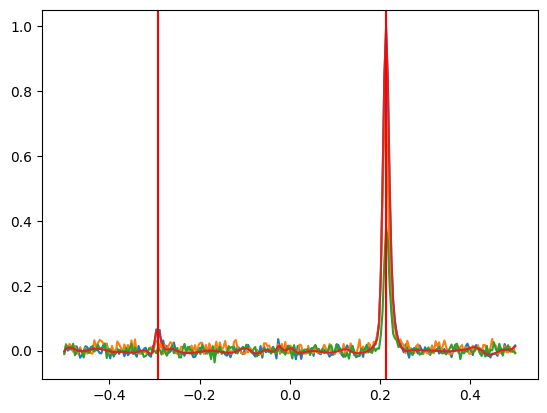

In [2402]:
profile_data = read_profile_data(FASTProfiles.loc['J1851+0118']['FASTfile_name'], 'FAST')
print(find_profile_type(profile_data[0]))
# profile_data[0] = scipy.ndimage.gaussian_filter1d(profile_data[0], profile_data[0].shape[0] // 500 + 1, mode='nearest')
phase = np.linspace(-0.5, 0.5, profile_data[0].shape[0])
noise = noise_estimation(profile_data[0])
spl = scipy.interpolate.splrep(phase, profile_data[0], s=profile_data[0].shape[0]*noise**2)
I_func = scipy.interpolate.BSpline(*spl)
plt.plot(phase, profile_data[0])
plt.plot(phase, profile_data[1])
plt.plot(phase, profile_data[2])
plt.plot(phase, I_func(phase))
peaks = find_peaks_number(profile_data[0])
# # print(find_peaks_number(I_func(phase)))
# # peaks, info = scipy.signal.find_peaks(I_func(phase), prominence=np.max(profile_data[0] * 0.05), height=4 * noise)
# print(noise_estimation(profile_data[0])*4)
for peak in peaks:
    plt.axvline(phase[peak], c='r')

## Mean angles estimation

In [1894]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()
print(MeerKATsubset[MeerKATsubset['P0'] <= 0.033].shape)
print(MeerKATsubset[(MeerKATsubset['P0'] > 0.033) & (MeerKATsubset['P0'] <= 0.5)].shape)
print(MeerKATsubset[(MeerKATsubset['P0'] > 0.5) & (MeerKATsubset['P0'] <= 1.0)].shape)
print(MeerKATsubset[MeerKATsubset['P0'] > 1.0].shape)

(1, 169)
(590, 169)
(413, 169)
(264, 169)


In [1169]:
MeerKATsubset['CHI'] = np.arcsin(5 * MeerKATsubset['P0']**(-0.5) / MeerKATsubset['W50']) * 180 / np.pi
FASTsubset['CHI'] = np.arcsin(5 * FASTsubset['P0']**(-0.5) / FASTsubset['W50']) * 180 / np.pi


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [1182]:
Ps = np.arange(0, 2.1, 0.5)

av_chis = np.zeros(Ps.shape[0]-1)
av_chisXs = np.zeros(Ps.shape[0]-1)
av_chisOs = np.zeros(Ps.shape[0]-1)
Ns_all = np.zeros(Ps.shape[0]-1)
Ns_Os = np.zeros(Ps.shape[0]-1)
Ns_Xs = np.zeros(Ps.shape[0]-1)

for i in range(Ps.shape[0]-1):
    av_chisXs[i] = MeerKATXs[(MeerKATXs['P0'] >= Ps[i]) & (MeerKATXs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Xs[i] =  MeerKATXs[(MeerKATXs['P0'] >= Ps[i]) & (MeerKATXs['P0'] < Ps[i+1])].count()['CHI']
    av_chisOs[i] = MeerKATOs[(MeerKATOs['P0'] >= Ps[i]) & (MeerKATOs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Os[i] =  MeerKATOs[(MeerKATOs['P0'] >= Ps[i]) & (MeerKATOs['P0'] < Ps[i+1])].count()['CHI']
    av_chis[i] = MeerKATsubset[(MeerKATsubset['P0'] >= Ps[i]) & (MeerKATsubset['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_all[i] = MeerKATsubset[(MeerKATsubset['P0'] >= Ps[i]) & (MeerKATsubset['P0'] < Ps[i+1])].count()['CHI']
    
    

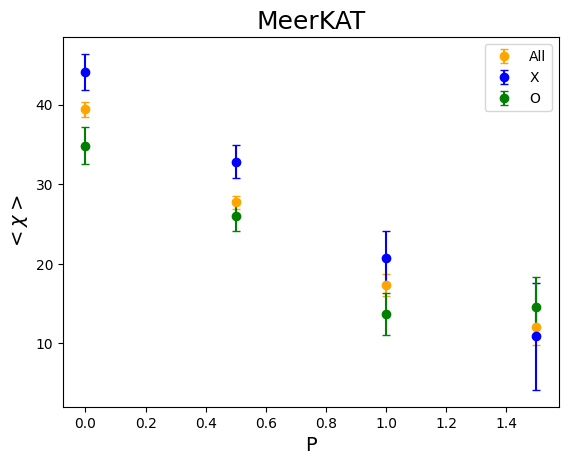

In [1184]:
plt.errorbar(Ps[:-1], av_chis, 15/np.sqrt(Ns_all), c='orange', label='All', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisXs, 15/np.sqrt(Ns_Xs), c='blue', label='X', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisOs, 15/np.sqrt(Ns_Os), c='green', label='O', fmt='o', capsize=3)

plt.xlabel('P', size=14)
plt.ylabel(r'$<\chi>$', size=14)
plt.title('MeerKAT', size=18)
plt.legend()
plt.savefig('MeerKAT_mean_angles.png', dpi=400)

In [1176]:
Ps = np.arange(0, 2.1, 0.5)

av_chis = np.zeros(Ps.shape[0]-1)
av_chisXs = np.zeros(Ps.shape[0]-1)
av_chisOs = np.zeros(Ps.shape[0]-1)
Ns_all = np.zeros(Ps.shape[0]-1)
Ns_Os = np.zeros(Ps.shape[0]-1)
Ns_Xs = np.zeros(Ps.shape[0]-1)

for i in range(Ps.shape[0]-1):
    av_chisXs[i] = FASTXs[(FASTXs['P0'] >= Ps[i]) & (FASTXs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Xs[i] =  FASTXs[(FASTXs['P0'] >= Ps[i]) & (FASTXs['P0'] < Ps[i+1])].count()['CHI']
    av_chisOs[i] = FASTOs[(FASTOs['P0'] >= Ps[i]) & (FASTOs['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_Os[i] =  FASTOs[(FASTOs['P0'] >= Ps[i]) & (FASTOs['P0'] < Ps[i+1])].count()['CHI']
    av_chis[i] = FASTsubset[(FASTsubset['P0'] >= Ps[i]) & (FASTsubset['P0'] < Ps[i+1])]['CHI'].mean()
    Ns_all[i] = FASTsubset[(FASTsubset['P0'] >= Ps[i]) & (FASTsubset['P0'] < Ps[i+1])].count()['CHI']
    
    

In [ ]:
plt.errorbar(Ps[:-1], av_chisXs, 15/np.sqrt(Ns_Xs), c='blue', label='X', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chisOs, 15/np.sqrt(Ns_Os), c='green', label='O', fmt='o', capsize=3)
plt.errorbar(Ps[:-1], av_chis, 15/np.sqrt(Ns_all), c='orange', label='All', fmt='o', capsize=3)

plt.xlabel('P', size=14)
plt.ylabel(r'$<\chi>$', size=14)
plt.title('FAST', size=18)
plt.legend()
plt.savefig('FAST_mean_angles.png', dpi=400)

## MeerKAT profiles test

In [2525]:
hdul = fits.open(MeerKATProfiles.loc['J0304+1932']['MeerKATfile_name']) #'J0108-1431'
hdul[4].header
DM = hdul[4].header['DM']
DC = DM / 2.41e-16
P = data.loc[hdul[0].header['SRC_NAME']]['P0']
print(DM, P)
freqs = hdul[4].data[0]['DAT_FREQ'] * 1e6
N = hdul[4].data[0]['DATA'][0][0].shape[0]
for channel in range(8):
    for stocks in range(4):
        hdul[4].data[0]['DATA'][stocks][channel] = np.roll(hdul[4].data[0]['DATA'][stocks][channel], 100+int(DC * (1/freqs[0]**2 - 1/freqs[channel]**2) * N / P))

15.7918053138488 1.387584446262276


In [2526]:
print(hdul[4].data[0]['DAT_OFFS'])
print(hdul[4].data[0]['DAT_WTS'])
print(hdul[4].data[0]['DAT_SCL'])
print(hdul[4].data[0]['DATA'].shape)
print(np.sum(freqs * hdul[4].data[0]['DAT_WTS'] / np.sum(hdul[4].data[0]['DAT_WTS']))/1e6)

[ 7.9348867e+03  7.7661104e+03  7.7323633e+03  7.7312295e+03
  6.8208545e+03  6.7487632e+03  6.9216143e+03  7.0163179e+03
  7.4023613e+01  5.5102520e+01  6.7774345e+01  1.1632709e+02
  1.6760023e+02  2.5916577e+02  1.7944576e+02  1.3057005e+02
  2.1308168e+01 -2.1783266e+00 -3.8057285e+01  3.2883965e+01
  4.9881519e+01  1.0403825e+02  6.9543663e+01 -2.2660744e+01
  9.7826567e+00  1.2986472e+01  4.1182137e+01  3.6678734e+00
  2.6087776e+01  2.0623892e+01  1.8502851e+01  3.3414352e+01]
[ 95956.05  127767.984 108682.3    68177.8   131353.61  138748.86
  92815.18  111300.49 ]
[0.00636864 0.0083817  0.01049758 0.00177463 0.00417708 0.00168783
 0.00094843 0.00143835 0.00415069 0.00448954 0.00458661 0.00065632
 0.00130061 0.00047889 0.00027944 0.00043606 0.0034463  0.00548362
 0.00754507 0.00127325 0.00298562 0.00115623 0.00062339 0.0008991
 0.000716   0.00095858 0.00124896 0.00026161 0.00064769 0.00028258
 0.00016953 0.00026052]
(4, 8, 1024)
1287.2962541128907


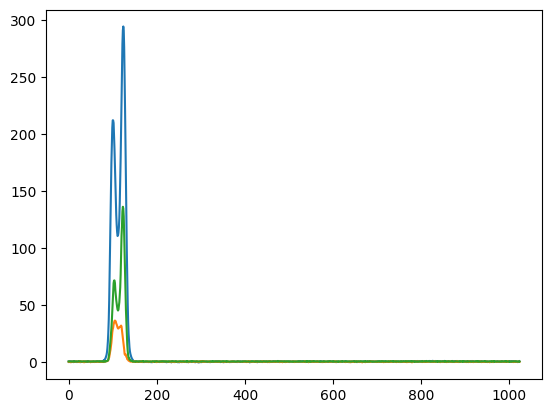

In [2528]:
I = np.zeros(N)
Q = np.zeros(N)
U = np.zeros(N)
V = np.zeros(N)

for channel in range(8):
    I += (hdul[4].data[0]['DATA'][0][channel].astype('int64') - noise_mean(hdul[4].data[0]['DATA'][0][channel].astype('int64'))) * hdul[4].data[0]['DAT_SCL'][8*0+channel] * (hdul[4].data[0]['DAT_WTS'][channel] / np.sum(hdul[4].data[0]['DAT_WTS']))
    Q += (hdul[4].data[0]['DATA'][1][channel].astype('int64') - noise_mean(hdul[4].data[0]['DATA'][1][channel].astype('int64'))) * hdul[4].data[0]['DAT_SCL'][8*1+channel] * (hdul[4].data[0]['DAT_WTS'][channel] / np.sum(hdul[4].data[0]['DAT_WTS']))
    U += (hdul[4].data[0]['DATA'][2][channel].astype('int64') - noise_mean(hdul[4].data[0]['DATA'][2][channel].astype('int64'))) * hdul[4].data[0]['DAT_SCL'][8*2+channel] * (hdul[4].data[0]['DAT_WTS'][channel] / np.sum(hdul[4].data[0]['DAT_WTS']))
    V += (hdul[4].data[0]['DATA'][3][channel].astype('int64') - noise_mean(hdul[4].data[0]['DATA'][3][channel].astype('int64'))) * hdul[4].data[0]['DAT_SCL'][8*3+channel] * (hdul[4].data[0]['DAT_WTS'][channel] / np.sum(hdul[4].data[0]['DAT_WTS']))
# print(noise_mean(hdul[4].data[0]['DATA'][0][channel].astype('int64')))
# plt.plot(hdul[4].data[0]['DATA'][0][channel].astype('int64'))
# Q = hdul[4].data[0]['DATA'][1][channel].astype('int64') * hdul[4].data[0]['DAT_SCL'][8*1+channel]
# U = hdul[4].data[0]['DATA'][2][channel].astype('int64') * hdul[4].data[0]['DAT_SCL'][8*2+channel]
# V = hdul[4].data[0]['DATA'][3][channel].astype('int64') * hdul[4].data[0]['DAT_SCL'][8*3+channel]
# w = hdul[4].data[0]['DAT_WTS'][channel] 
# shift = hdul[4].data[0]['DAT_OFFS'][8*i+channel]
# scale = hdul[4].data[0]['DAT_SCL'][8*i+channel]
# plt.plot(hdul[4].data[0]['DATA'][i][0])
# alpha = np.max(Stocks_data)/np.min(Stocks_data)
# print(35 * alpha / (alpha - 1))
# print(35 / (np.max(Stocks_data) - np.min(Stocks_data)))
plt.plot(I)
plt.plot(V)
# plt.plot(I1 - np.median(I1))
plt.plot(np.sqrt(Q**2 + U**2))
# plt.plot((Q - noise_mean(Q)))
# plt.plot((U - noise_mean(U)))



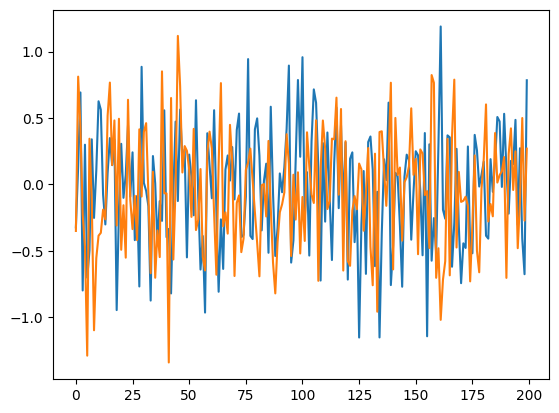

In [2502]:
# plt.plot(np.sqrt((Q[800:1000]-np.median(Q))**2 + (V[800:1000]-np.median(V))**2))
# plt.plot(V[800:1000] - np.median(V))
plt.plot(Q[800:1000] - np.median(Q))
plt.plot(U[800:1000] - np.median(U))
# plt.plot(I[800:1000] - np.median(I))

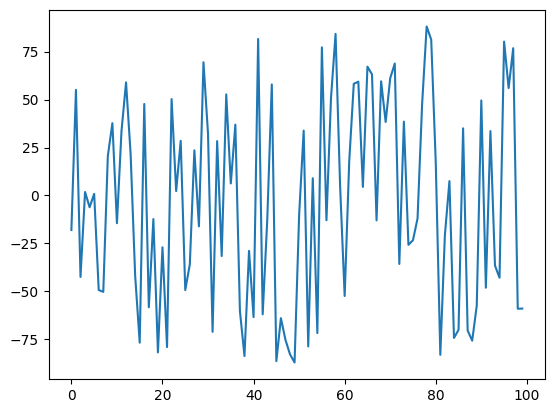

In [1744]:
plt.plot(np.arctan((U[800:900] - np.median(U)) / (Q[800:900] - np.median(Q))) * 180 / np.pi)

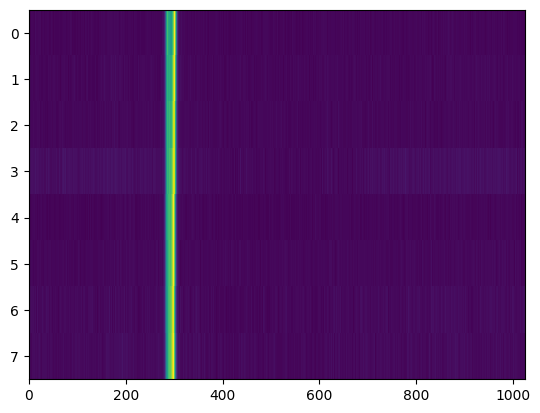

In [1693]:
plt.imshow(hdul[4].data[0]['DATA'][0].astype('int64'), aspect='auto', interpolation='none')

0.6778200278662097
single


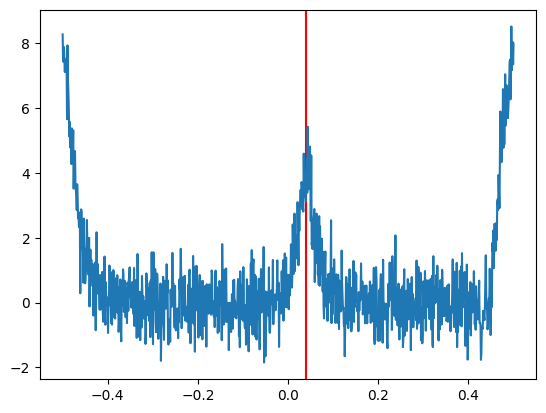

In [2542]:
# psr = np.random.choice(orthogonal_PSRs)
# print(psr)
pulsar_data = read_profile_data(MeerKATProfiles.loc['J1913+0832']['MeerKATfile_name'], 'MeerKAT') #J0514-4407, J1057-5226
phase = np.linspace(-0.5, 0.5, pulsar_data[0].shape[0])
noise = noise_estimation(pulsar_data[0])
print(noise)
spl = scipy.interpolate.splrep(phase, pulsar_data[0], s=pulsar_data[0].shape[0]*(noise/2)**2)
I_func = scipy.interpolate.BSpline(*spl)
# plt.plot(phase, I_func(phase))
peaks = find_peaks_number(pulsar_data[0])
for peak in peaks:
    plt.axvline(phase[peak], c='r')
plt.plot(phase, pulsar_data[0])
print(find_profile_type(pulsar_data[0]))

In [2458]:
MeerKATsubset = data[data.index.isin(MeerKATnames)].copy()
orthogonalMeerKATs = data[data.index.isin(orthogonal_PSRs_MeerKAT)].copy()
FASTsubset = data[data.index.isin(FASTnames)].copy()
orthogonalFASTs = data[data.index.isin(orthogonal_PSRs_FAST)].copy()

In [2459]:
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.03) & (orthogonalMeerKATs['P0'] < 0.1)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.1) & (orthogonalMeerKATs['P0'] < 0.2)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.2) & (orthogonalMeerKATs['P0'] < 0.3)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.3) & (orthogonalMeerKATs['P0'] < 0.4)]))
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > 0.4) & (orthogonalMeerKATs['P0'] < 0.5)]))


1
3
8
5
1


In [2468]:
P1 = 0.4
P2 = 0.5
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > P1) & (orthogonalMeerKATs['P0'] < P2)]) / (len(MeerKATsubset[(MeerKATsubset['P0'] > P1) & (MeerKATsubset['P0'] < P2)]))*100)
print(len(orthogonalMeerKATs[(orthogonalMeerKATs['P0'] > P1) & (orthogonalMeerKATs['P0'] < P2)]))
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > P1) & (orthogonalFASTs['P0'] < P2)]) / (len(FASTsubset[(FASTsubset['P0'] > P1) & (FASTsubset['P0'] < P2)]))*100)
print(len(orthogonalFASTs[(orthogonalFASTs['P0'] > P1) & (orthogonalFASTs['P0'] < P2)]))


0.8264462809917356
1
1.8181818181818181
1


In [ ]:
1, 5, 5, 3, 1